In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from utils.score import ScoreRegression
from utils.forecasting import BoostedHybrid

plot_params = {
    "color": "0.75",
    "style": ".-",
    "markeredgecolor": "0.25",
    "markerfacecolor": "0.25",
    "legend": False,
}

In [2]:
train = pd.read_csv("datasets/features/train.csv", parse_dates=["date"])
train["date"] = train.date.dt.to_period("D")
train = train.set_index(["date"]).sort_index()

# Create target matrix
y_train = train.loc[:, ["sales"]]

fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y_train.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

x_train = dp.in_sample()
x_train["NewYearsDay"] = x_train.index.dayofyear == 1

x_train = pd.concat([x_train, train.drop("sales", axis=1)], axis=1)

In [3]:
y_train.head()

,sales
date,
2013-01-01,0.0
2013-01-01,0.0
2013-01-01,0.0
2013-01-01,0.0
2013-01-01,0.0


In [4]:
x_train.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,store_nbr,city,state,type,cluster,family,onpromotion,dcoilwtico,day_week,holiday_or_weekday
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,18,12,3,13,0,0,93.14,1,0
2013-01-01,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,18,12,3,13,1,0,93.14,1,0
2013-01-01,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,18,12,3,13,2,0,93.14,1,0
2013-01-01,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1,18,12,3,13,3,0,93.14,1,0
2013-01-01,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1,18,12,3,13,4,0,93.14,1,0


In [3]:
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)

model.fit(x_train, y_train)

In [10]:
test = pd.read_csv("datasets/features/test.csv", parse_dates=["date"])
test = test[test["date"] < "2017-01-16"]
test["date"] = test.date.dt.to_period("D")
test = test.set_index(["date"]).sort_index()

y_test = test.loc[:, ["sales"]]

x_test = dp.out_of_sample(steps=15)
x_test["NewYearsDay"] = x_test.index.dayofyear == 1

x_test = pd.concat([x_test, test.drop("sales", axis=1)], axis=1)

In [11]:
y_test.head()

,sales
date,
2017-01-01,0.0
2017-01-01,0.0
2017-01-01,0.0
2017-01-01,0.0
2017-01-01,0.0


In [12]:
x_test.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,store_nbr,city,state,type,cluster,family,onpromotion,dcoilwtico,day_week,holiday_or_weekday
2017-01-01,1.0,2596375.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1,18,12,3,13,0,0,53.75,6,2
2017-01-01,1.0,2596375.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1,18,12,3,13,1,0,53.75,6,2
2017-01-01,1.0,2596375.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1,18,12,3,13,2,0,53.75,6,2
2017-01-01,1.0,2596375.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1,18,12,3,13,3,0,53.75,6,2
2017-01-01,1.0,2596375.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1,18,12,3,13,4,0,53.75,6,2


In [13]:
y_pred = model.predict(x_test).clip(0.0)

In [14]:
y_pred.head()

,sales
2017-01-01,0.000000
2017-01-01,0.000000
2017-01-01,0.000000
2017-01-01,1072.735412
2017-01-01,0.000000


In [15]:
from utils.score import ScoreRegression

scores = ScoreRegression()
scores.calculate(y_test, y_pred)
print(scores)

ScoreRegression(r2=0.8806296333026088, mse=270083.5305848969, mae=182.3092705443628, rmsle=1.9385771302181687)


In [16]:
y_pred.reset_index(names=["date"]).head()

,date,sales
0,2017-01-01,0.000000
1,2017-01-01,0.000000
2,2017-01-01,0.000000
3,2017-01-01,1072.735412
4,2017-01-01,0.000000


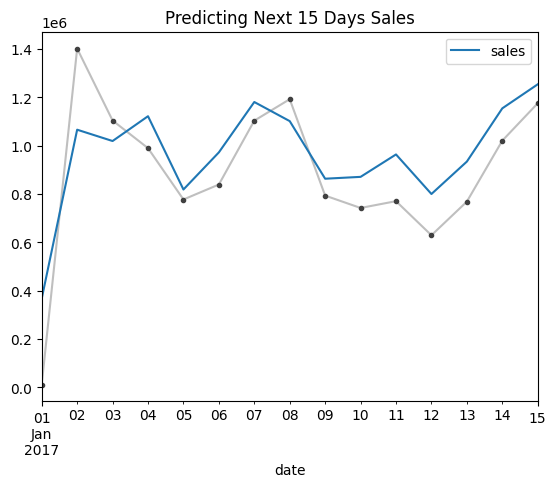

In [18]:
y_test_group = y_test.reset_index().groupby(by=["date"]).sum()
y_pred_group = y_pred.reset_index(names=["date"]).groupby(by=["date"]).sum()

ax = y_test_group.plot(**plot_params)
ax = y_pred_group.plot(ax=ax)
ax.set_title(f'Predicting Next 15 Days Sales');

In [10]:
y_train_reset = y_train.reset_index()
y_train_2017 = y_train_reset[(y_train_reset["date"]>="2016-01-01")&(y_train_reset["date"]<"2016-07-01")].groupby(by=["date"]).sum()
y_train_2017.head()

,sales
date,
2016-01-01,1.643339e+04
2016-01-02,1.066677e+06
2016-01-03,1.226736e+06
2016-01-04,9.559569e+05
2016-01-05,8.353204e+05


In [25]:
y_pred_reset = model.y_fit.reset_index()
y_pred_group = y_pred_reset[(y_pred_reset["date"]>="2016-01-01")&(y_pred_reset["date"]<"2016-07-01")].groupby(by=["date"]).sum()

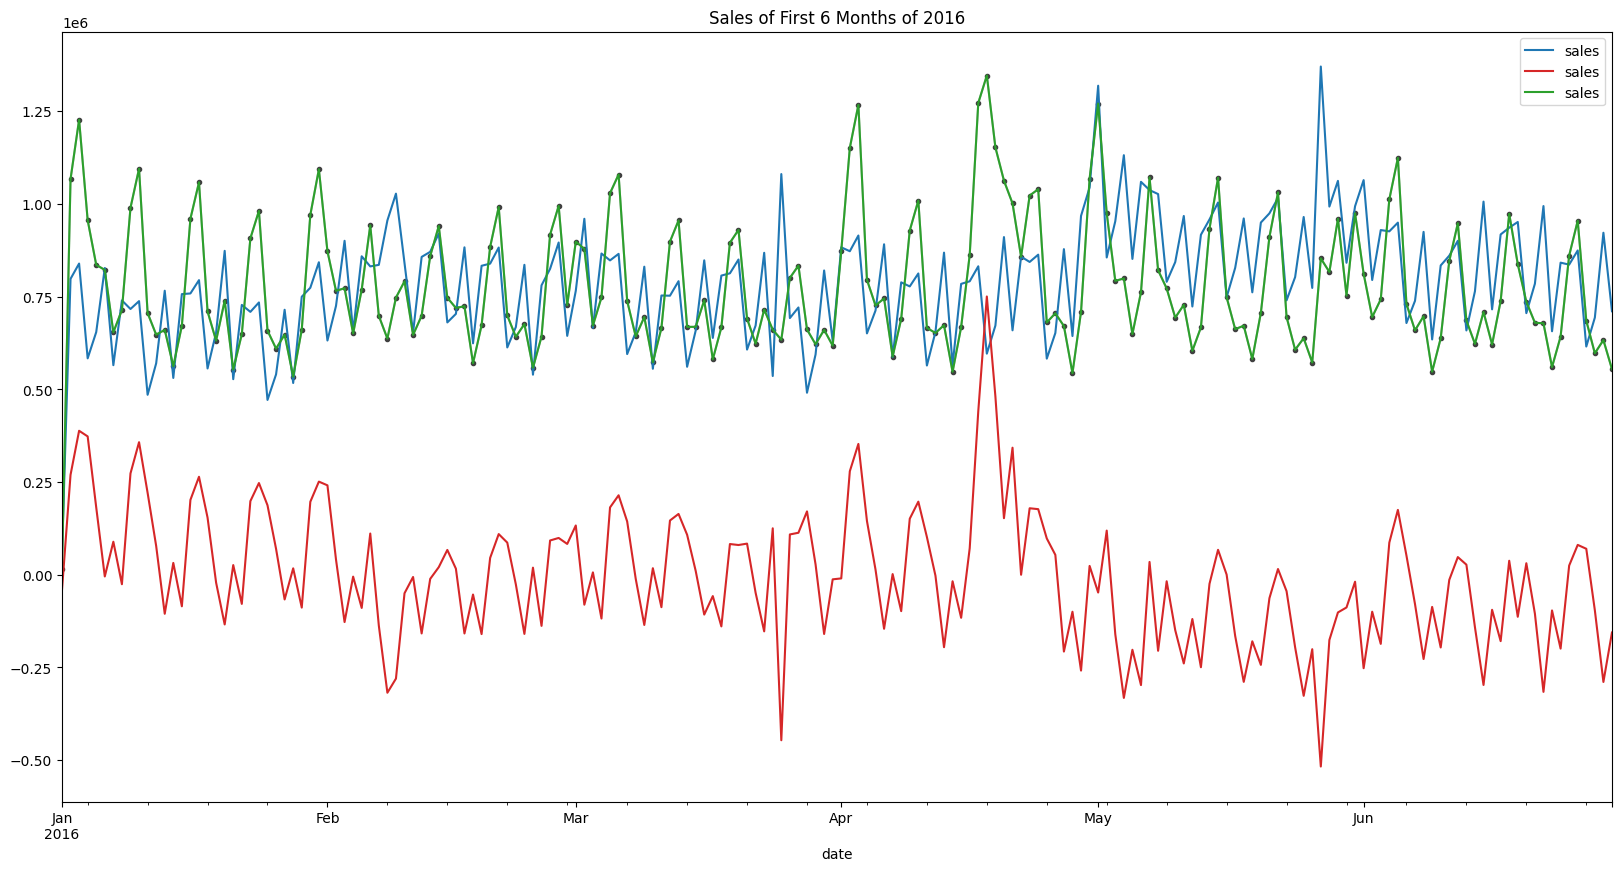

In [39]:
ax = y_train_2017.plot(**plot_params, figsize=(20,10))
ax = y_pred_group.plot(ax=ax)
ax = y_resid_group.plot(ax=ax, color='C3')
ax = y_pred_sum.plot(ax=ax, color='C2')
ax.set_title(f'Sales of First 6 Months of 2016');

In [ ]:
# ScoreRegression(
#     r2=0.5104164609961745,
#     mse=659989.2999611218,
#     mae=309.13351983413094,
#     rmsle=2.03782441484438,
# )

# ScoreRegression(
#     r2=0.8786452960734695,
#     mse=274573.22781499434,
#     mae=192.56270849225814,
#     rmsle=2.08945924035806,
# )

In [35]:
train_all = pd.read_csv("datasets/features/tranformed.csv", parse_dates=["date"])
train_all["date"] = train_all.date.dt.to_period("D")
train_all = train_all.set_index(["date"]).sort_index()

# Create target matrix
y_train_all = train_all.loc[:, ["sales"]]

fourier = CalendarFourier(freq="M", order=2)
dp = DeterministicProcess(
    index=y_train_all.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

x_train_all = dp.in_sample()

x_train_all = pd.concat([x_train_all, train_all.drop("sales", axis=1)], axis=1)

In [36]:
model_submit = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)

model_submit.fit(x_train_all, y_train_all)

In [61]:
submit = pd.read_csv("datasets/features/submit/transformed.csv", parse_dates=["date"])
submit["date"] = submit.date.dt.to_period("D")
submit = submit.set_index(["date"]).sort_index()

x_submit = dp.out_of_sample(steps=16)

x_submit = pd.concat([x_submit, submit.drop("id", axis=1)], axis=1)

In [62]:
submit.head()

,id,store_nbr,city,state,type,cluster,family,onpromotion,dcoilwtico,day_week,holiday_or_weekday
date,,,,,,,,,,,
2017-08-16,3000888,1,18,12,3,13,0,0,46.8,2,1
2017-08-16,3000889,1,18,12,3,13,1,0,46.8,2,1
2017-08-16,3000890,1,18,12,3,13,2,2,46.8,2,1
2017-08-16,3000891,1,18,12,3,13,3,20,46.8,2,1
2017-08-16,3000892,1,18,12,3,13,4,0,46.8,2,1


In [63]:
x_submit.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,store_nbr,city,state,type,cluster,family,onpromotion,dcoilwtico,day_week,holiday_or_weekday
2017-08-16,1.0,3000889.0,0.0,1.0,0.0,0.0,0.0,0.0,0.101168,-0.994869,...,1,18,12,3,13,0,0,46.8,2,1
2017-08-16,1.0,3000889.0,0.0,1.0,0.0,0.0,0.0,0.0,0.101168,-0.994869,...,1,18,12,3,13,1,0,46.8,2,1
2017-08-16,1.0,3000889.0,0.0,1.0,0.0,0.0,0.0,0.0,0.101168,-0.994869,...,1,18,12,3,13,2,2,46.8,2,1
2017-08-16,1.0,3000889.0,0.0,1.0,0.0,0.0,0.0,0.0,0.101168,-0.994869,...,1,18,12,3,13,3,20,46.8,2,1
2017-08-16,1.0,3000889.0,0.0,1.0,0.0,0.0,0.0,0.0,0.101168,-0.994869,...,1,18,12,3,13,4,0,46.8,2,1


In [64]:
y_pred_submit = model_submit.predict(x_submit).clip(0.0)

In [65]:
y_pred_submit.head()

,sales
2017-08-16,10.734987
2017-08-16,0.000000
2017-08-16,0.000000
2017-08-16,2513.140527
2017-08-16,0.000000


In [67]:
submit["sales"] = y_pred_submit.sales

In [68]:
submit.head()

,id,store_nbr,city,state,type,cluster,family,onpromotion,dcoilwtico,day_week,holiday_or_weekday,sales
date,,,,,,,,,,,,
2017-08-16,3000888,1,18,12,3,13,0,0,46.8,2,1,10.734987
2017-08-16,3000889,1,18,12,3,13,1,0,46.8,2,1,0.000000
2017-08-16,3000890,1,18,12,3,13,2,2,46.8,2,1,0.000000
2017-08-16,3000891,1,18,12,3,13,3,20,46.8,2,1,2513.140527
2017-08-16,3000892,1,18,12,3,13,4,0,46.8,2,1,0.000000


In [69]:
y_submit = submit[["id", "sales"]]

In [70]:
y_submit.head()

,id,sales
date,,
2017-08-16,3000888,10.734987
2017-08-16,3000889,0.000000
2017-08-16,3000890,0.000000
2017-08-16,3000891,2513.140527
2017-08-16,3000892,0.000000


In [71]:
y_submit.shape

(28512, 2)

In [72]:
y_submit.to_csv('submission.csv', index=False)